# E-commerce

### Dataset Source - https://www.kaggle.com/carrie1/ecommerce-data
#### Contributed by:
   * **Lisa Patel**
   * **Binny Chauhan**
   * **Vishakha Srivastava**
   * **Hithesh Sekhar Bathala**

![Image of meme](https://www.softwaresuggest.com/blog/wp-content/uploads/2018/10/ecommerce2-1.png)

# E-Commerce Data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The Data contains the information about customer's purchases of an UK online retailer. There are nearly about 4000 customers and their purchases during the period of one year.<BR>

The analysis will be divided into sections:

1. EDA and Data Cleaning
2. Sales Trend Analysis
3. Recency, Frequency and Monetary Value Analysis (RFM)
4. Product Recommendation for customer & Apriori analysis to promote basket sale
    


In [121]:
#Required Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

###  Exploring the content of variables


This dataframe contains 8 variables that correspond to:<br>
<b>CustomerID: </b>Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br>
<b>StockCode:</b> Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br>
<b>Description:</b> Product (item) name. Nominal.<br>
<b>Quantity:</b> The quantities of each product (item) per transaction. Numeric.<br>
<b>UnitPrice: </b>Unit price. Numeric, Product price per unit in sterling.<br>
<b>Country:</b> Country name. Nominal, the name of the country where each customer resides.<br>
<b>InvoiceDate:</b> Invice Date and time. Numeric, the day and time when each transaction was generated.<br>
<b>InvoiceNo:</b> Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. <br> If this code starts with letter 'c', it indicates a cancellation.

## Exploratory Data Analysis

#### Findings


1. 89% of the orders are from United Kingdom.
2. 16.47% of the orders are cancelled orders.
3. The top 5 countries to receive the highest number of orders are:
   *    United Kingdom
   *    Germany
   *    France
   *    Ireland
   *    Spain
4. 79.01% of revenue is generated by 20% of the products.
5. Most products are sold on Thursday in contrast Saturday and Sunday which have very low transactions.
6. Pre-christmas season starts in September and peaks in November.
7. 16.76% of the product descriptions are invalid.
8. 1.09% of the total products have unit price as zero.
9. For the month of December 2011, we have only 2 weeks of data (Weeks 50,51,52 are missing).
10. Maximum number of rewards are given in the month of November which is also the month of maximum number of sales.  

In [122]:
#read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

# show first lines
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [123]:
from pandas_profiling import ProfileReport
import pandas_profiling as pdp

In [124]:
#Profiling to understand the data 
#profile = ProfileReport(df_initial)

### Overview of the data using pandas profiling 

In [125]:
#pdp.ProfileReport(df_initial)

#### Missing Values
The data has 3.1% values as NA. So dropping these rows 

In [126]:
df_initial.dropna(inplace= True)

In [127]:
df_initial.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [128]:
df_initial.shape

(406829, 8)

#### Customers and products
What are the total number of customers, products and transactions?

In [129]:
print("Total No. of Products, Transactions, Customers")
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])


Total No. of Products, Transactions, Customers


,products,transactions,customers
quantity,3684,22190,4372


#### Products purchased in each transaction
How many products are purchased in each transaction?

In [130]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:20].sort_values('Number of products',ascending = False)

,CustomerID,InvoiceNo,Number of products
13,12349,577609,73
7,12347,573511,47
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
6,12347,562032,22
5,12347,556201,18
9,12348,539318,17
14,12350,543037,17
15,12352,544156,15


The above table gives the analysis for the number of products purchased sorted in descending order.

#### Time Period for Data
What is the time period of the data?

In [131]:
df_initial["InvoiceDate"] = pd.to_datetime(df_initial.InvoiceDate, cache=True)

df_initial.InvoiceDate.max() - df_initial.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [132]:
df_initial2 = df_initial.copy()

#### Cancelled Orders 
What is the percentage of cancelled orders?

In [133]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]

print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


#### Countries

How many unique countries are delivered by the retailer?

In [134]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print("Total number of countries delivered by the retailer are :", df_initial2.Country.nunique())

Total number of countries delivered by the retailer are : 37


What are the number of orders per country?

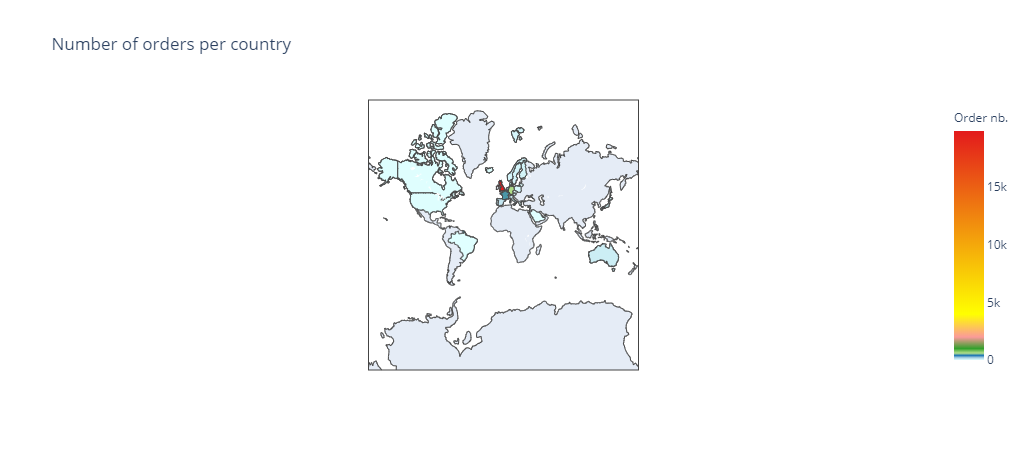

In [135]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

Which countries made the most tranctions?

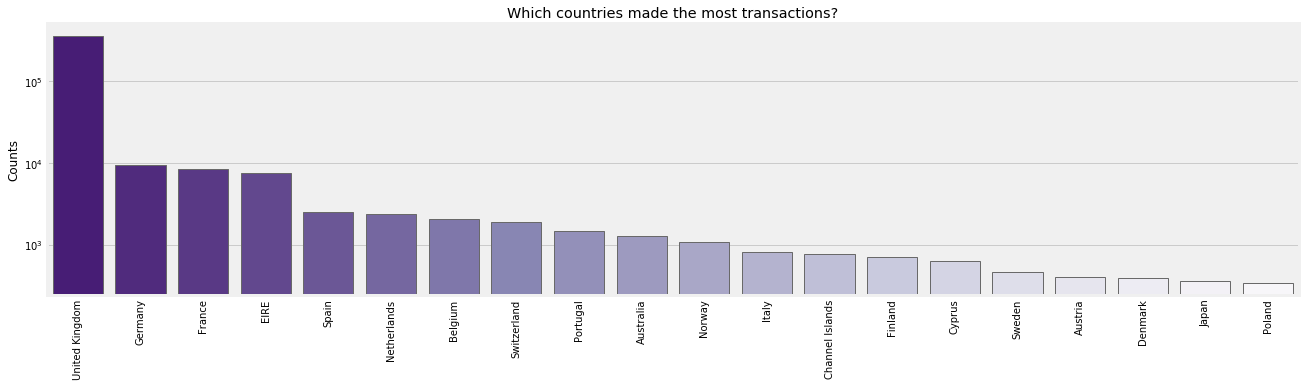

In [136]:
#Number of countries 
country_counts = df_initial2.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

In [137]:
df_initial2.loc[df_initial2.Country=="United Kingdom"].shape[0] / df_initial2.shape[0] * 100

88.95088599878574

Maximum orders are from UK that is, 89% of orders are from UK

#### Stock Codes

How many unique stockcodes do we have?

In [138]:
print("Total number of countries in the dataset are :",df_initial2.StockCode.nunique())

Total number of countries in the dataset are : 3684


Which are the most common stockcodes?

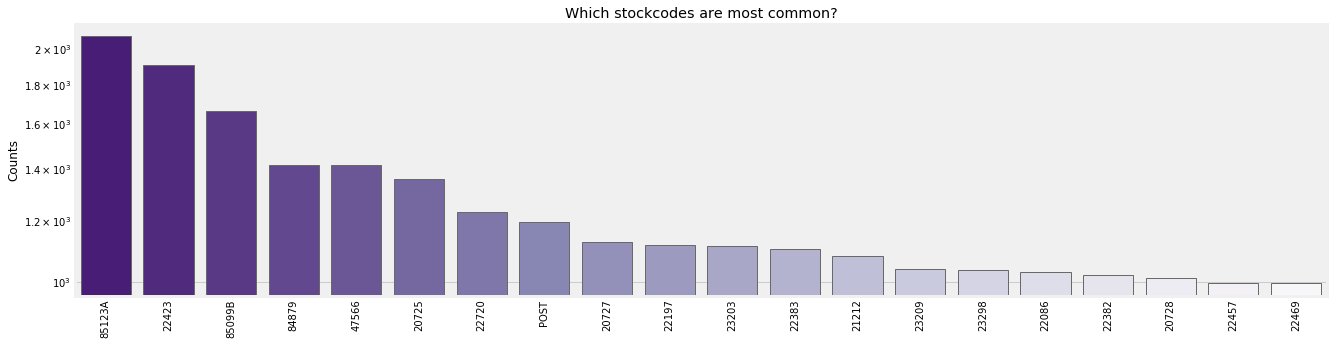

In [139]:
#The stockcodes of most common items ordered 
stockcode_counts = df_initial2.StockCode.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(stockcode_counts.index, stockcode_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which stockcodes are most common?");
plt.xticks(rotation=90);
plt.yscale("log")

While doing the analysis we found POST in the most common stockcode counts. 
To make sure there no such strange occurences in stock code, we did an analysis on stockcodes. We found stockcode does not have specific description to each product. The stockcode could be a detailed indication for a product, Example: Bags may have different variants types such as Purse, Backpack but the still come the category of Bag.

In [140]:
#defining the variables
df_initial2['length_stockcode']=df_initial2.StockCode.str.len()
print("\nlength of StockCode:\n",df_initial2.length_stockcode.value_counts(sort=True)\
      .reset_index(name='no_rows').rename(columns={'index':'length of StockCode'}))



length of StockCode:
    length of StockCode  no_rows
0                    5   371020
1                    6    33593
2                    4     1216
3                    1      542
4                    7      296
5                    2      134
6                    3       16
7                   12       12


Since most rows have StockCode of length 5 or 6, this is considered the legitimate StockCode referring to item description

#### Descriptions

What are the most common descriptions?

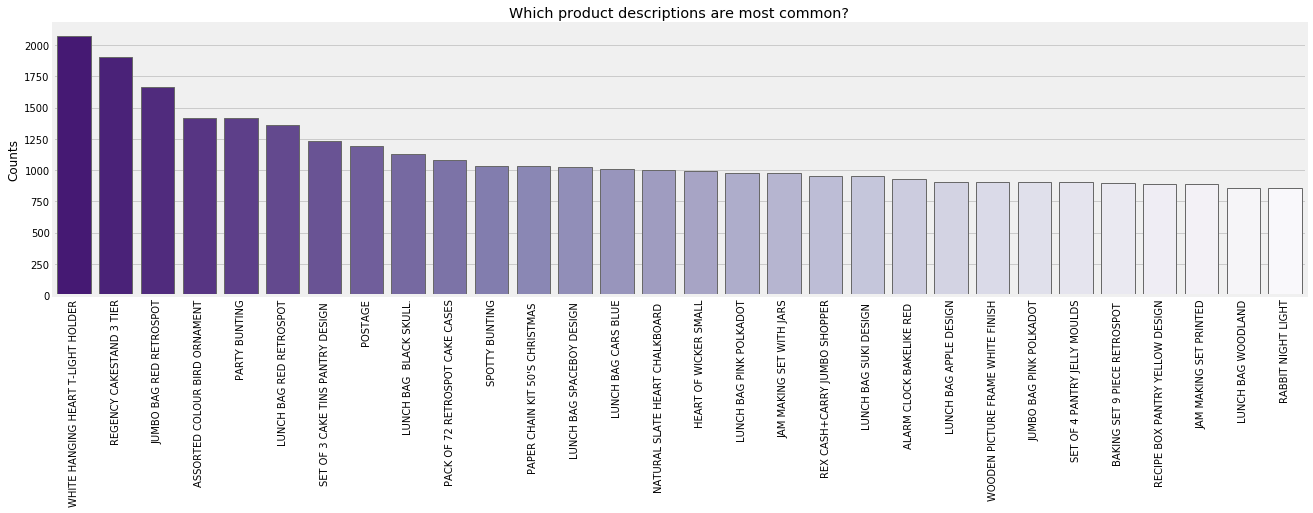

In [141]:
description_counts = df_initial2.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

We found that most of the descriptions correspond to a similar product type. Descriptions may contain other attributes such as shape, color of the product. Above are the descriptions of most common products sold by the customer. Most of the description contains uppercase characters.

Analysis to check of the case of letters & length in Description as there are some units with lowercase letters in their description

In [142]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())
df_initial2["DescriptionLength"] = df_initial2.Description.apply(lambda l: len(l))
df_initial2["LowCharsInDescription"] = df_initial2.Description.apply(lambda l: count_lower_chars(l))

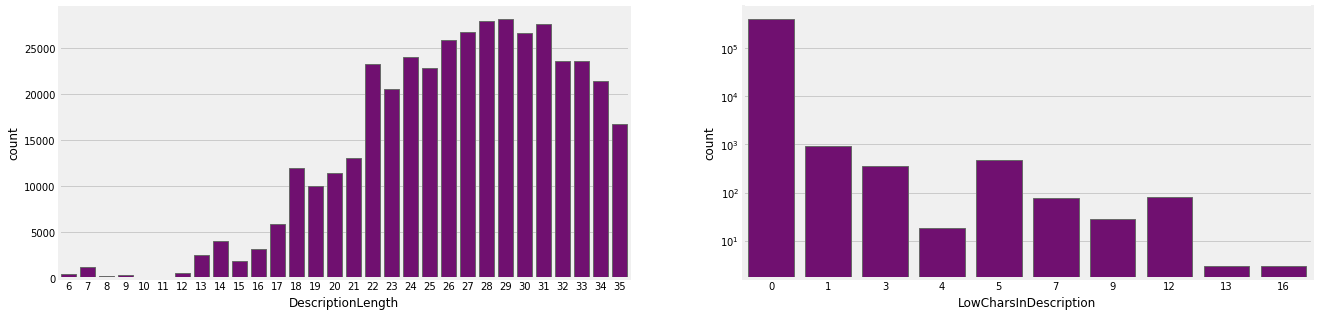

In [143]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(df_initial2.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(df_initial2.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

We found the Decription length of most of the products was between 21-35.
There were many description with lowercase chars, so we did some further analysis on it

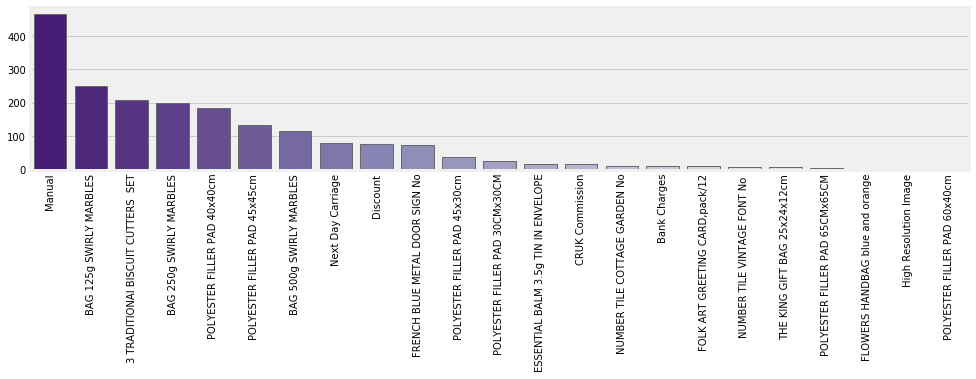

In [144]:
lowchar_counts = df_initial2.loc[df_initial2.LowCharsInDescription > 0].Description.value_counts()
plt.figure(figsize=(15,3))
sns.barplot(lowchar_counts.index, lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

In [145]:
#Strange descriptions : Manual, NextDay Carriage, Bank Charges,CRUK Comission, High Resolution Image 
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

df_initial2["UpCharsInDescription"] = df_initial2.Description.apply(lambda l: count_upper_chars(l))
print('{}% of the product descriptions are invalid'.format(round(df_initial2.loc[df_initial2.UpCharsInDescription <= 5].Description.value_counts().sum()/df_initial2.Description.nunique()*100,2)))
df_initial2["UpCharsInDescription"] = df_initial2.Description.apply(lambda l: count_upper_chars(l))
df_initial2.loc[df_initial2.UpCharsInDescription <=5].Description.value_counts()


16.76% of the product descriptions are invalid


Manual                   465
Next Day Carriage         80
Discount                  77
CRUK Commission           16
Bank Charges              12
High Resolution Image      3
Name: Description, dtype: int64

We found out the Descriptions with lowercase characters had some strange descriptions, Example: Bank charges is the reverted entry of charge on cancelled orders. So, we will be dropping all such invalid descriptions for a better analysis 

How many unique descriptions do we have?

In [146]:
df_initial2.Description.nunique()

3896

How many unique stockcodes do we have?

In [147]:
df_initial2.StockCode.nunique()

3684

The number of Descriptions & Stockcode does not match, which means one stockcode can have multiple Descriptions 

In [148]:
# stockcodes with multiple descriptions
df_initial2.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23196     4
23236     4
23203     3
23370     3
22776     3
17107D    3
23396     3
22937     3
23231     3
23535     3
Name: Description, dtype: int64

The above Stockcodes have multiple descriptions for a single stockcode 

In [149]:
#EX stockcode "23196" has 4 different descriptions 
df_initial2.loc[df_initial2.StockCode == "23196"].Description.value_counts()

VINTAGE LEAF MAGNETIC NOTEPAD         221
RETRO LEAVES MAGNETIC NOTEPAD          20
RETO LEAVES MAGNETIC SHOPPING LIST      3
LEAVES MAGNETIC  SHOPPING LIST          2
Name: Description, dtype: int64

### Unit Price of Products


In [150]:
df_initial2.UnitPrice.describe()

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

The Average price of a product is 3.46.
The minimum Unit Price of a product is zero, so we are assuming these are the products given to customer as rewards/free

In [151]:
## plotting values with price 0 
print('{}% of the total products have unit price as zero'.format(round(df_initial2[(df_initial2['UnitPrice']==0)].shape[0]/len(df_initial['StockCode'].value_counts())*100,2)))

1.09% of the total products have unit price as zero


In [152]:
df_free = df_initial2.loc[df_initial2.UnitPrice == 0]

We created a sepreate Dataframe for the free items and did monthly analysis on it to find out the trends of giving free items per each month

In [153]:
dates = list(df_free['InvoiceDate'])
D = {}

In [154]:
for date in dates:
    if str(date).split(' ')[0].split('-')[1] in D:
        D[str(date).split(' ')[0].split('-')[1]]+=1
    else:
        D[str(date).split(' ')[0].split('-')[1]]=1

Text(0.5, 1.0, 'Number of Free rewards given per Months')

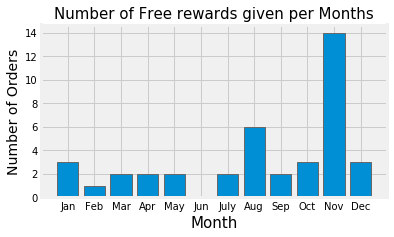

In [155]:
fig= plt.figure(figsize=(6,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
ax = plt.bar(['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec'],[D['01'],D['02'],D['03'],D['04'],D['05'],0,D['07'],D['08'],D['09'],D['10'],D['11'],D['12']])
plt.xlabel('Month',fontsize=15)
plt.ylabel('Number of Orders',fontsize=14)
plt.title('Number of Free rewards given per Months',fontsize=15)

The number of maximum rewards given in the month of November which is also the month with maximum number of transactions.
Also, no rewards/Free products were given in the month of June

#### Invoice Number

Invoice no. length is not the same for all entires. Also, some invoices characters along with numeric values in them. So, we did a basic analysis about what these characters indicate

In [156]:
## length of invoice
df_initial2['length_invoiceno']=df_initial2.InvoiceNo.str.len()
print("Length of InvoiceNo:\n",df_initial2.length_invoiceno.value_counts(sort=True)\
      .reset_index(name='no_rows').rename(columns={'index':'length of InvoiceNo'}))
## invoice first letter is C for all invoice where length is 7 
df_initial2['invoiceno_letter1']=df_initial2['InvoiceNo'].str[0]

print("\nFirst letter for invoice:\n",df_initial2.invoiceno_letter1.value_counts(sort=True)\
      .reset_index(name='no_rows').rename(columns={'index':'invoice first letter'}))
print("\nCross table first letter for invoice against invoiceno length:\n"\
      ,pd.crosstab(df_initial2['invoiceno_letter1'],df_initial2['length_invoiceno'],margins=True))

Length of InvoiceNo:
    length of InvoiceNo  no_rows
0                    6   397924
1                    7     8905

First letter for invoice:
   invoice first letter  no_rows
0                    5   397924
1                    C     8905

Cross table first letter for invoice against invoiceno length:
 length_invoiceno        6     7     All
invoiceno_letter1                      
5                  397924     0  397924
C                       0  8905    8905
All                397924  8905  406829


Invoice with first letter 'C' are the orders that are cancelled. All cancellations have negative quantites but positive, non-zero unit prices. Given this data we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done. Also customer may have ordered multiple items and cancelled a few.
So we will be dropping all the entries with cancelled orders for accurate analysis 

#### Quantity

In [157]:
#Describing quantity 
df_initial2.Quantity.describe()

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

 Quantity outliers is due to cancelled orderes. These are because cancelled order entries will reflect negative prices. We will be dropping these values in data cleaning

#### General overview of the invalid entries

In [158]:
print("\nDescription for StockCode with length below 5 or above 8 :")
df_initial2[(df_initial2['length_stockcode']<5) | (df_initial2['length_stockcode']>8)]\
[['length_stockcode','invoiceno_letter1','StockCode','Description']]\
.groupby(by=['length_stockcode','StockCode','invoiceno_letter1']).Description.value_counts().reset_index(name='Frequency')


Description for StockCode with length below 5 or above 8 :


,length_stockcode,StockCode,invoiceno_letter1,Description,Frequency
0,1,D,C,Discount,77
1,1,M,5,Manual,290
2,1,M,C,Manual,175
3,2,C2,5,CARRIAGE,133
4,2,C2,C,CARRIAGE,1
5,3,DOT,5,DOTCOM POSTAGE,16
6,4,CRUK,C,CRUK Commission,16
7,4,PADS,5,PADS TO MATCH ALL CUSHIONS,4
8,4,POST,5,POSTAGE,1099
9,4,POST,C,POSTAGE,97


### Data Cleaning

1. Rows where unit price is 0
2. Rows with negative quantity
3. Rows with cancelled orders 
4. Rows with stockcode length less than 5 & greater than 6

In [159]:
df_clean = df_initial2.copy()

In [160]:
#number of rows with unit price 0
print('no of rows with Unit price 0 are :',df_initial2[(df_initial2['UnitPrice']==0)].shape[0])

no of rows with Unit price 0 are : 40


In [161]:
#Dropping number of rows with unit price 0
df_clean = df_clean[df_clean['UnitPrice'] != 0]

In [162]:
#The number of rows with negative Quantity
print("The number of rows with negative Quantity:",sum(n < 0 for n in df_initial2.Quantity))

The number of rows with negative Quantity: 8905


In [163]:
#Dropping rows with negative Quantity
df_clean = df_clean[df_clean['Quantity'] > 0]

In [164]:
#Number of rows with cancelled orders
print('Number of rows with cancelled orders:',df_initial2[(df_initial2['invoiceno_letter1']=='C')].shape[0])

Number of rows with cancelled orders: 8905


In [165]:
#Dropping Number of rows with cancelled orders
df_clean=df_clean[df_clean['invoiceno_letter1']!='C']

In [166]:
#Number of rows with stockcode length less than 5 & greater than 6
print('Number of rows with stockcode length less than 5 & greater than 6')
df_initial2.otherdesc=df_clean[(df_clean['length_stockcode']<5) | (df_clean['length_stockcode']>6) \
                       | (df_clean['StockCode']=='BANK CHARGES')]
print(df_initial2.otherdesc.shape[0])

Number of rows with stockcode length less than 5 & greater than 6
1838


In [167]:
#Dropping number of rows with stockcode length less than 5 & greater than 6
df_clean=df_clean[~((df_clean['length_stockcode']<5) | (df_clean['length_stockcode']>6) \
                       | (df_clean['StockCode']=='BANK CHARGES'))]

In [168]:
#Dropping unecessary columns used in analysis  
df_clean= df_clean.drop(columns =['length_stockcode', 'DescriptionLength','LowCharsInDescription','UpCharsInDescription','length_invoiceno','invoiceno_letter1']) 

Shape of data after data cleaning

In [169]:
#Shape of data after cleaning 
print('Shape of data after data cleaning is : ',df_clean.shape) 

Shape of data after data cleaning is :  (396046, 8)


### Overview of the data after data cleaning using Pandas Profiling 

In [170]:
#profile = ProfileReport(df_clean)

In [171]:
#pdp.ProfileReport(df_clean)

## Weekly and Monthly Sales Trend Analysis

## Insight 1 

### Findings:
#### Weekly Trends
1. Thursday seems to be the day on which most products are sold. 
2. In contrast Saturday and Sunday have very low transactions

#### Monthly Trends
1. The pre-Christmas season starts in September and shows a peak in November for United Kingdom. 
2. For the rest of the countries, the pre-season shows a peak in October.
2. February and April are month with very low sales



From Exploratory data analysis, we already know that around 90% of the sales transactions are from United Kingdom. So lets check out the sales trend only for United Kingdom first to get some insights.

Create a new dataframe which contains records only for United Kingdom

In [172]:
df_uk = df_clean[df_clean.Country == "United Kingdom"]

In [173]:
df_uk.shape

(353756, 8)

Using the Invoicedate field, identify Year, Month, Week, Day for each record and store in a seperate column

In [174]:
df_uk["Revenue"] = df_uk.Quantity * df_uk.UnitPrice
df_uk["Year"] = df_uk.InvoiceDate.dt.year
df_uk["Quarter"] = df_uk.InvoiceDate.dt.quarter
df_uk["Month"] = df_uk.InvoiceDate.dt.month
df_uk["Week"] = df_uk.InvoiceDate.dt.week
df_uk["Weekday"] = df_uk.InvoiceDate.dt.weekday
df_uk["Day"] = df_uk.InvoiceDate.dt.day
df_uk["Date"] = pd.to_datetime(df_uk[['Year', 'Month', 'Day']])

In [175]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,2010-12-01


In [176]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Day",
                    "StockCode"]

Group the data by Stockcode and sum the quantity and revenue for each stock code

In [177]:
daily_data = pd.DataFrame(df_uk.groupby(grouped_features).Quantity.sum(),columns=["Quantity"])
daily_data["Revenue"] = df_uk.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,1,10002,12,10.20
1,2010-12-01,2010,4,12,48,2,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,1,15044B,1,2.95
4,2010-12-01,2010,4,12,48,2,1,15056N,50,236.30


Plot the quantities of total items sold per day along with 30 day rolling average for the entire year

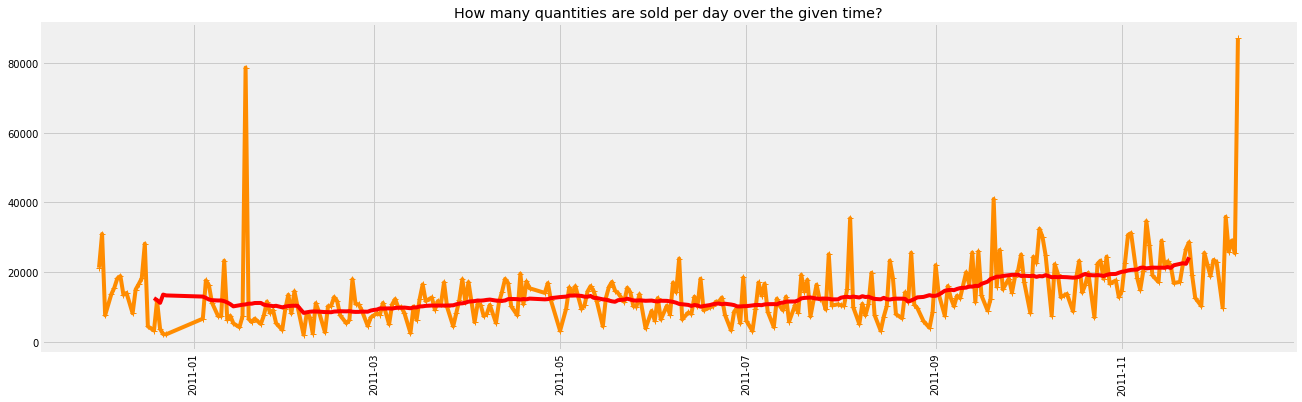

In [178]:
plt.figure(figsize=(20,6))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

Plot the total sales per weekday and per month

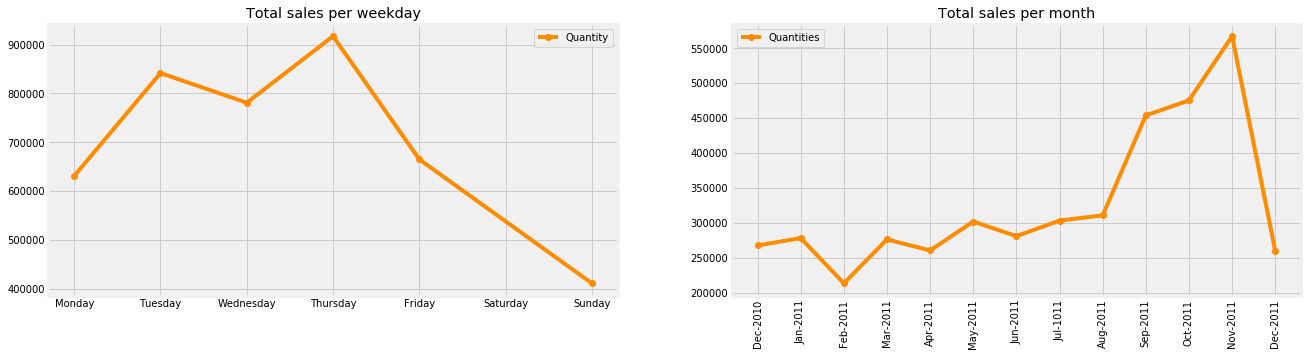

In [179]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

In [180]:
daily_data[(daily_data.Year==2011)&(daily_data.Month==12)].Week.value_counts()

49    4813
48    2825
Name: Week, dtype: int64

## Graphical findings:

#### Weekly Trends
1. Thursday seems to be the day on which most products are sold. 
2. In contrast Saturday and Sunday have very low transactions

#### Monthly Trends
1. The pre-Christmas season starts in September and shows a peak in November for United Kingdom. 
2. February and April are month with very low sales

###### For the month of Dec 2011, we have only 2 weeks of data (Weeks 50,51,52 are missing) which is the reason for such a sharp decline in sales. So we can ignore it

Now let check if this pattern hold true for rest of the countries as well

Create a new dataframe which contains the remanining 10% record for countries like France, Germany etc.

In [181]:
df_nonuk = df_initial[df_initial.Country != "United Kingdom"]

In [182]:
df_nonuk.shape

(44951, 8)

Using the Invoicedate field, identify Year, Month, Week, Day for each record and store in a seperate column

In [183]:
df_nonuk["Revenue"] = df_nonuk.Quantity * df_nonuk.UnitPrice
df_nonuk["Year"] = df_nonuk.InvoiceDate.dt.year
df_nonuk["Quarter"] = df_nonuk.InvoiceDate.dt.quarter
df_nonuk["Month"] = df_nonuk.InvoiceDate.dt.month
df_nonuk["Week"] = df_nonuk.InvoiceDate.dt.week
df_nonuk["Weekday"] = df_nonuk.InvoiceDate.dt.weekday
df_nonuk["Day"] = df_nonuk.InvoiceDate.dt.day
df_nonuk["Date"] = pd.to_datetime(df_nonuk[['Year', 'Month', 'Day']])

In [184]:
df_nonuk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Date
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,2010,4,12,48,2,1,2010-12-01
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,2010,4,12,48,2,1,2010-12-01
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,2010,4,12,48,2,1,2010-12-01
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,2010,4,12,48,2,1,2010-12-01
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,2010,4,12,48,2,1,2010-12-01


Group the data by Stockcode and sum the quantity and revenue for each stock code

In [185]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Day",
                    "StockCode"]

In [186]:
daily_data_nonUK = pd.DataFrame(df_nonuk.groupby(grouped_features).Quantity.sum(),columns=["Quantity"])
daily_data_nonUK["Revenue"] = df_nonuk.groupby(grouped_features).Revenue.sum()
daily_data_nonUK = daily_data_nonUK.reset_index()
daily_data_nonUK.head()

,Date,Year,Quarter,Month,Week,Weekday,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,1,10002,48,40.80
1,2010-12-01,2010,4,12,48,2,1,20685,2,15.90
2,2010-12-01,2010,4,12,48,2,1,20712,10,19.50
3,2010-12-01,2010,4,12,48,2,1,20713,10,19.50
4,2010-12-01,2010,4,12,48,2,1,20914,-1,-2.95


Plot the quantities of total items sold per day along with 30 day rolling average for the entire year

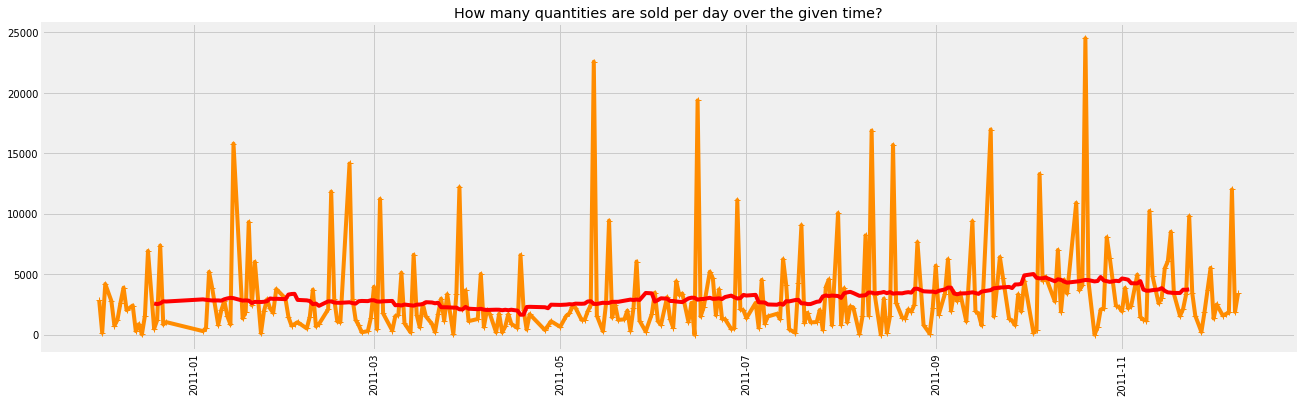

In [187]:
plt.figure(figsize=(20,6))
plt.plot(daily_data_nonUK.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data_nonUK.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

Plot the total sales per weekday and per month

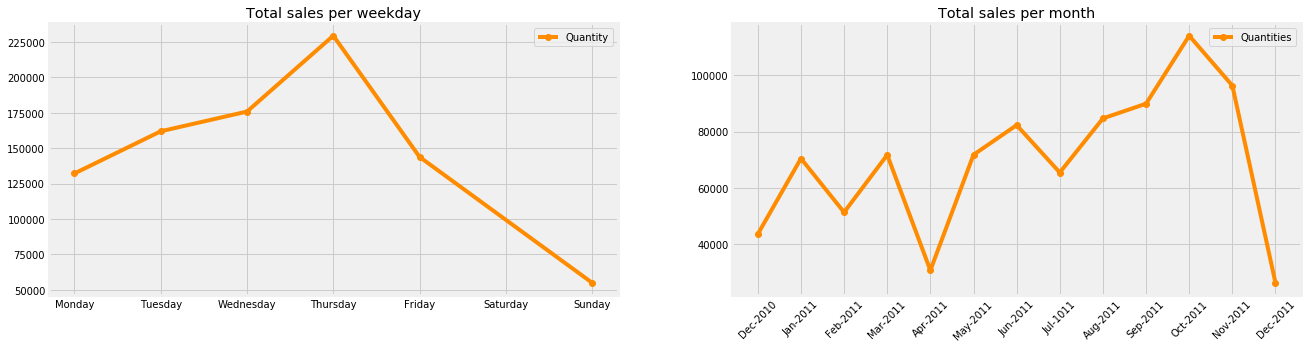

In [188]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data_nonUK.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data_nonUK.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=45)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

### Graphical findings for rest of the countries:
#### Weekly Trends
Weekly trends remains same as that for sales in UK with Thursday being the day when most of the sales happen

#### Monthly Trends
Monthly trend is also similar to that of UK except for the fact that sales peaks in October instead of November.

### Managerial Insight for all the countries:
1. It is clearly evident from the analysis that Saturday and Sunday have very low product sales compared to the other days in the week. So partnering with a credit card company such as HSBC or Citi and running offers like additional 10 % discount on weekends, if products are bought using the partner companies credit card could boost the sales.


2. Similarly, running promotional offer in the Month of Febuary and April could boost the sale for those months

### Pareto Analysis - Validating the 80:20 Rule

##### Hypothesis: Validate if 80% of the Revenue is generated from the sales of 20 % of Stocks

In [189]:
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,1,10002,12,10.20
1,2010-12-01,2010,4,12,48,2,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,1,15044B,1,2.95
4,2010-12-01,2010,4,12,48,2,1,15056N,50,236.30


In [190]:
len(daily_data.Revenue)

204462

Calculate the total Revenue for each stockcode

In [191]:
daily_data_updated = daily_data.groupby("StockCode")['Revenue'].sum()
daily_data_updated = pd.DataFrame(daily_data_updated).reset_index()
daily_data_updated.columns = ['StockCode', 'Revenue']

In [192]:
daily_data_updated.head()

,StockCode,Revenue
0,10002,340.85
1,10080,114.41
2,10120,38.43
3,10123C,3.25
4,10124A,6.72


In [193]:
daily_data_updated.Revenue.sort_values(ascending=False)

2396    168469.60
1285    110990.20
3228     95013.95
1994     80291.44
3214     77371.57
          ...    
2810         0.95
3444         0.85
3458         0.85
458          0.84
2815         0.42
Name: Revenue, Length: 3638, dtype: float64

In [194]:
len(daily_data_updated.StockCode.unique())

3638

There are 3638 total unique Stock codes

In [195]:
len(daily_data_updated)*0.20

727.6

We will sort the revenues in decending order, sum the revenue for the initial 728 rows and divide it with the total revenue

In [196]:
print ('{} % of the revenue is generated from Sales of 20 % of the Stocks'\
       .format(round((daily_data_updated.Revenue.sort_values(ascending=False)[:728].sum() \
        /daily_data_updated.Revenue.sum())*100,2)))

79.01 % of the revenue is generated from Sales of 20 % of the Stocks


#### This suggest that our 80:20 rules holds true for revenues in this data set


# RFM (Recency Frequency Monetary) Analysis
RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.

So let's perform customer segmenation on the given dataset using RFM Analysis..


![Image of RFM](https://mk0exponeav2vrysryl9.kinstacdn.com/wp-content/uploads/2018/09/customer-segments-RFM-analysis-1024x536.jpg)

## Recency – How recently did the customer purchase?

Storing latest date in our dataset


In [197]:
import datetime as dt
latest_date = dt.date(2011,12,9)

In [198]:
df = df_initial.copy()
df['date'] = pd.DatetimeIndex(df.InvoiceDate).date

Grouping the datagrame by customer by last date they purchased an item...


In [199]:
recency_df = df.groupby(['CustomerID'],as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


Calculate how often the customer is purchasing with reference to latest date in days..


In [200]:
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (latest_date - x).days)

In [201]:
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,325
1,12347,2011-12-07,2
2,12348,2011-09-25,75
3,12349,2011-11-21,18
4,12350,2011-02-02,310


## Frequency – How often do they purchase?

In [202]:
frequency_df = df.copy()
frequency_df= df.groupby('CustomerID',as_index=False).agg({'InvoiceNo': lambda num: len(num)})
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


## Monetary Value – How much do they spend?


Calculating the total cost..

In [203]:
df['Total_cost'] = df['UnitPrice'] * df['Quantity']

Total purchase by a customer with respect to latest date..


In [204]:
monetary_df=df.groupby('CustomerID',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['CustomerID','Monetary']

In [205]:
monetary_df.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


We don't need 'LastPurchaseDate' column since we already calculated recency:

In [206]:
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)


Combining all dataframes (recency, frquency, monetary) together..


In [207]:
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')
rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')
rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.00
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40


Let’s examine the distribution of our Recency, Frequency, and Monetary..

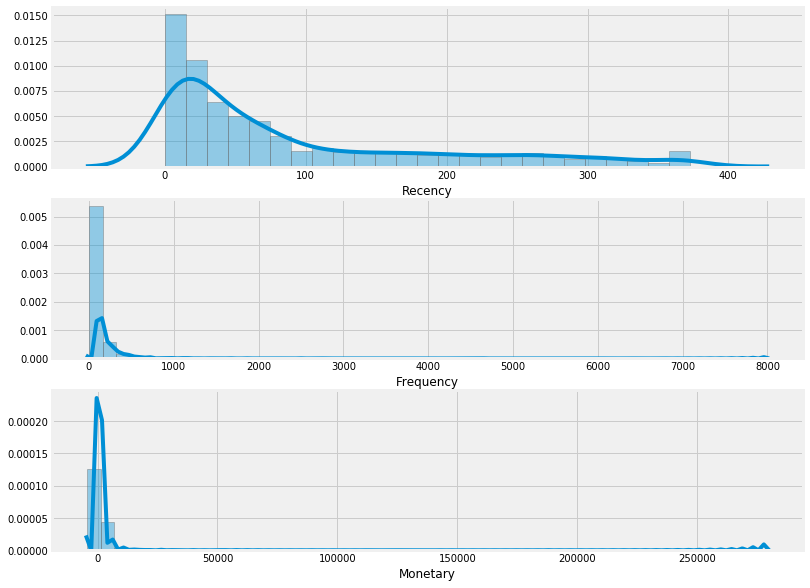

In [208]:
plt.figure(figsize=(12,10))
# Recency
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Frequecy
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Monetary
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])

# Show the plot
plt.show()

This plot provides us with some very interesting insights and how skewed our data is. The important thing to take note here is that we will be grouping these values in quantiles..

In [209]:
rfm['r_quartile'] = pd.qcut(rfm['Recency'], 4, ['4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['Frequency'], 4, ['1','2','3','4'])
rfm['m_quartile'] = pd.qcut(rfm['Monetary'], 4, ['1','2','3','4'])

rfm['r_quartile'] = rfm['r_quartile'].astype(int)
rfm['f_quartile'] = rfm['f_quartile'].astype(int)
rfm['m_quartile'] = rfm['m_quartile'].astype(int)


In [210]:
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346,325,2,0.00,1,1,1
12347,2,182,4310.00,4,4,4
12348,75,31,1797.24,2,2,4
12349,18,73,1757.55,3,3,4
12350,310,17,334.40,1,1,2


Summing up the scores..

In [211]:
rfm['RFM_Score'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
rfm['RFM_Score'].head()

CustomerID
12346     3
12347    12
12348     8
12349    10
12350     4
Name: RFM_Score, dtype: int64

Defining RFM levels for each score range..

In [212]:
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

#Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12346,325,2,0.00,1,1,1,3,Require Activation
12347,2,182,4310.00,4,4,4,12,Can't Loose Them
12348,75,31,1797.24,2,2,4,8,Champions
12349,18,73,1757.55,3,3,4,10,Can't Loose Them
12350,310,17,334.40,1,1,2,4,Needs Attention


Finally, we can then group our customers by their RFM level:

Calculating average values for each RFM_Level, and return a size of each segment ..



In [213]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

rfm_level_agg

Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      24.9     194.9   4127.4  1692
Champions             62.0      57.1    972.3   466
Loyal                 78.5      39.5    725.4   447
Needs Attention      174.6      13.9    227.0   390
Potential             94.1      28.6    491.7   466
Promising            151.7      21.1    343.8   520
Require Activation   264.6       7.8    109.1   391

But before we end, let’s create a nice visualization for our data!

In [214]:
import squarify

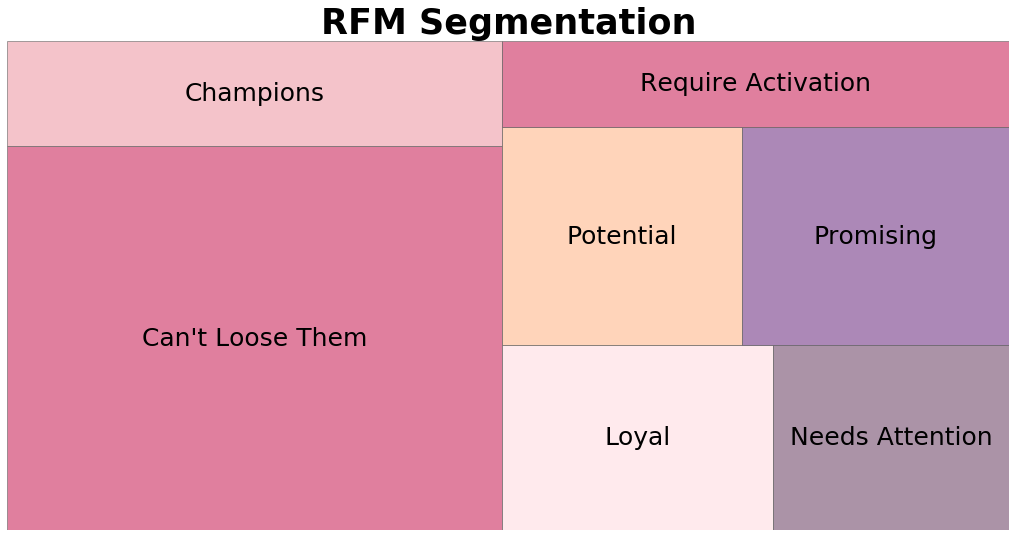

In [215]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6, color=["#cc2b5e","#ee9ca7","#ffdde1","#734b6d","#ffb88c","#753a88"], text_kwargs={'fontsize':25} )
plt.title("RFM Segmentation",fontsize=35,fontweight="bold")
plt.axis('off')
plt.show()

# Managerial Insights 2:

From here, we can see that a large percentage (~60%) of our customers are in the top tier RFM levels..

The other groups will require some work:

1. Potential — high potential to enter our loyal customer segments, the store should distribute freebies to get more attention from them!

2. Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.

3. Needs Attention — made some initial purchase but have not seen them since. They could have had a bad customer experience or product-market fit They need to be aware about the brand.

4. Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back..

#### Moving on to our next analysis ... because...

![Image of meme](https://miro.medium.com/max/430/0*AP1iU-48Mr4TPg9U)

## Insight 3
### Product Recommendation for customers

Product recommendation using Natural Language Processing to understand the "trending products" by leveraging data on the most purchased items for a given time period. Creating clusters of similar buying pattern helps to identify the products of interest, which could be shown to customers of the same cluster.


### Interactive Tool for Managers/Sellers to club products to improve sales

Using market basket analysis to check for association rules across set of products bought by the customers and provide insight on the potential sale increase by selling products together.


In [216]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from random import randint
from wordcloud import WordCloud
from collections import Counter

In [217]:
print('Dataframe dimensions:', df_clean.shape)
print(df_clean['Description'].head())

Dataframe dimensions: (396046, 8)
0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: Description, dtype: object


In [218]:
#Description - unique ones
df_desc = pd.DataFrame(df_clean['Description'].unique()).rename(columns = {0:'Description'})
print(df_desc.shape)
print(df_desc)

(3870, 1)
                              Description
0      WHITE HANGING HEART T-LIGHT HOLDER
1                     WHITE METAL LANTERN
2          CREAM CUPID HEARTS COAT HANGER
3     KNITTED UNION FLAG HOT WATER BOTTLE
4          RED WOOLLY HOTTIE WHITE HEART.
...                                   ...
3865            LETTER "W" BLING KEY RING
3866            LETTER "Z" BLING KEY RING
3867       PINK CRYSTAL SKULL PHONE CHARM
3868   CREAM HANGING HEART T-LIGHT HOLDER
3869          PAPER CRAFT , LITTLE BIRDIE

[3870 rows x 1 columns]


In [219]:
# Explore the punctuations in the data
find_dict={}
newp='"#$%&\'()*+-/:;<=>@[\]^_`{|}~.?'
for i, row in df_desc.iterrows():
    for c in newp:
        if c in row['Description']:
            val=find_dict.get(c,'')
            find_dict[c]=val+'|'+row['Description']

In [220]:
#print(find_dict)
print(find_dict.keys())

dict_keys(['-', '.', "'", '/', '+', '&', '"', '(', ')'])


![NLP Pipeline](NLP1.PNG)

#### Feature Transformers

In [221]:
# Fucntion to Process Punctuations 
def punc_processing(st):
    for i,c in enumerate(list(st)):
        if c == '\'':
            #Clean example like 'n'
            if i==0:
                #print(st)
                st_clean=st[1:(len(st)-1)]
                #print(st_clean)
                return st_clean
            #Clean example like b'fly
            if i==1:
                #print(st)
                st_clean=st[2:]
                #print(st_clean)
                return st_clean
            #clean example like mother's
            if i!=0 and st[i-1]!=' ':
                #print(st)
                st_clean=st[:(i)]+st[(i+2):]
                #print(st_clean)
                return st_clean
        if c == '"':
            #clean example like "glamorous"
            if i==0:
                #print(st)
                st_clean=st[1:(len(st)-1)]
                #print(st_clean)
                return st_clean        
    return st

In [222]:
newp='["&\'()+-/[\].]'
front_quotation='[\"\'(]'
end_quotation='[\"\')]'
connect_quotation='&/+,'
toker = RegexpTokenizer('[a-z]+'+newp+'[a-z]+|[a-z]+|'+front_quotation+'[a-z]+'+end_quotation)
wordnet_lemmatizer=WordNetLemmatizer()
stopWords = set(stopwords.words('english'))
stopWords.update(['small', 'large', 'jumbo', 'set', 'pink', 'blue', 'tag', 'red', 'white'])

In [223]:
# Import NLTK - Natural Language Toolkit
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [224]:
df_desc['token']=None
df_desc['token_list']=None

for i, row in df_desc.iterrows():
    descp_st=row['Description'].lower()
    for quot in connect_quotation:
        descp_st=descp_st.replace(quot, ' '+quot+' ')
    #Tokenization
    descp_l=toker.tokenize(descp_st)
    #Punctuation pre-processing
    descp_l=[punc_processing(x) for x in descp_l]
    #Stop words removal
    descp_l2=[x for x in descp_l if x not in stopWords ]
    
    #test if use steming to pre-process - The result might not be an actual dictionary word.
    #descp_l2=[stemmer.stem(x) for x in descp_l2]  
    
    #Lematization - The result is always a dictionary word.
    descp_l2=[wordnet_lemmatizer.lemmatize(x) for x in descp_l2]
    df_desc.loc[i,'token_list']=descp_l2
    df_desc.loc[i, 'token']=' '.join(descp_l2)

In [225]:
#test if stop word or words mislead clustering correctly
print('Number of common stop words:', len(stopwords.words('english')))
print('Example of common stop words(not all stop words listed):', stopwords.words('english')[:30], '\n')
print('Number of unwanted words in these sample:', len(['small', 'large', 'jumbo', 'set', 'pink', 'blue', 'tag', 'red', 'white']))
print('Example of unwanted words in these sample:', ['small', 'large', 'jumbo', 'set', 'pink', 'blue', 'tag', 'red', 'white'])

Number of common stop words: 179
Example of common stop words(not all stop words listed): ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself'] 

Number of unwanted words in these sample: 9
Example of unwanted words in these sample: ['small', 'large', 'jumbo', 'set', 'pink', 'blue', 'tag', 'red', 'white']


In [256]:
#Test if punctation are filttered correctly
# find_dict={}
# newp='"#$%&\'()*+-/:;<=>@[\]^_`{|}~.?'
# for i, row in df_desc.iterrows():
#     for c in newp:
#         if c in row['Description']:
#             print('Punctuation:',c)
#             print('Original description:',row['Description'])
#             print('After pre-processing:',row['token_list'], '\n')
#             newp.replace(c, '')
#             break

In [257]:
#Test if stopwords filttered correctly
# col='OF'
# for i, row in df_desc.iterrows():
#     if col in row['Description']:
#         print('Remove the word:',col)
#         print(row['Description'])
#         print(row['token_list'])
#         print('\n')

In [228]:
#test if lematize correctly - check AGED
# col='EARRINGS'
# for i, row in df_desc.iterrows():
#     if col in row['Description']:
#         print('Lematize the word:',col)
#         print(row['Description'])
#         print(row['token_list'])
#         print('\n')

#### Vectorization as bag-of-words

In [229]:
#Convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(min_df=1)

data_desc_doc = vectorizer.fit_transform(df_desc['token'])
feature_name = vectorizer.get_feature_names()

In [230]:
print('Number of words appeared in corpus:', len(feature_name))
print('Example of words appeared in corpus(not all listed):',feature_name[:30], '\n')

Number of words appeared in corpus: 1732
Example of words appeared in corpus(not all listed): ['abc', 'abstract', 'acapulco', 'account', 'acrylic', 'address', 'ade', 'adult', 'advent', 'afghan', 'aged', 'ahoy', 'aid', 'air', 'airline', 'airmail', 'alarm', 'album', 'all', 'allium', 'alphabet', 'alpine', 'aluminium', 'amber', 'amelie', 'amethyst', 'anemone', 'angel', 'animal', 'ant'] 



In [231]:
data_desc_doc

<3870x1732 sparse matrix of type '<class 'numpy.int64'>'
	with 14225 stored elements in Compressed Sparse Row format>

In [232]:
print(data_desc_doc.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### K-means clustering

In [233]:
def findBestN(matrix):
    for n in range(3,15):
        kmeans = KMeans(n_clusters = n, n_init=20, random_state=0 )
        kmeans.fit(matrix)
        clusters = kmeans.predict(matrix)
        silhouette_avg = silhouette_score(matrix, clusters)
        print("For n_clusters =", n, "The average silhouette_score is :", silhouette_avg)
        
findBestN(data_desc_doc)

For n_clusters = 3 The average silhouette_score is : 0.024146494889620482
For n_clusters = 4 The average silhouette_score is : 0.0291239387916171
For n_clusters = 5 The average silhouette_score is : 0.03380993847867713
For n_clusters = 6 The average silhouette_score is : 0.037799566563479124
For n_clusters = 7 The average silhouette_score is : 0.02668435117770689
For n_clusters = 8 The average silhouette_score is : 0.03663166936008644
For n_clusters = 9 The average silhouette_score is : 0.025142575745756665
For n_clusters = 10 The average silhouette_score is : 0.027603236780736895
For n_clusters = 11 The average silhouette_score is : 0.04451170822435463
For n_clusters = 12 The average silhouette_score is : 0.04524884216959034
For n_clusters = 13 The average silhouette_score is : 0.04753231003466462
For n_clusters = 14 The average silhouette_score is : 0.04727248897786825


In [234]:
best_no_of_cluster= 12
#k means clustering
kmeans = KMeans(n_clusters = best_no_of_cluster, n_init=20, random_state=0 )
kmeans.fit(data_desc_doc)
km_result=kmeans.predict(data_desc_doc)
df_desc['cluster_group']=pd.Series(km_result)

df_desc.head()


,Description,token,token_list,cluster_group
0,WHITE HANGING HEART T-LIGHT HOLDER,hanging heart t-light holder,"[hanging, heart, t-light, holder]",9
1,WHITE METAL LANTERN,metal lantern,"[metal, lantern]",6
2,CREAM CUPID HEARTS COAT HANGER,cream cupid heart coat hanger,"[cream, cupid, heart, coat, hanger]",1
3,KNITTED UNION FLAG HOT WATER BOTTLE,knitted union flag hot water bottle,"[knitted, union, flag, hot, water, bottle]",8
4,RED WOOLLY HOTTIE WHITE HEART.,woolly hottie heart,"[woolly, hottie, heart]",1


### Word Cloud by Cluster

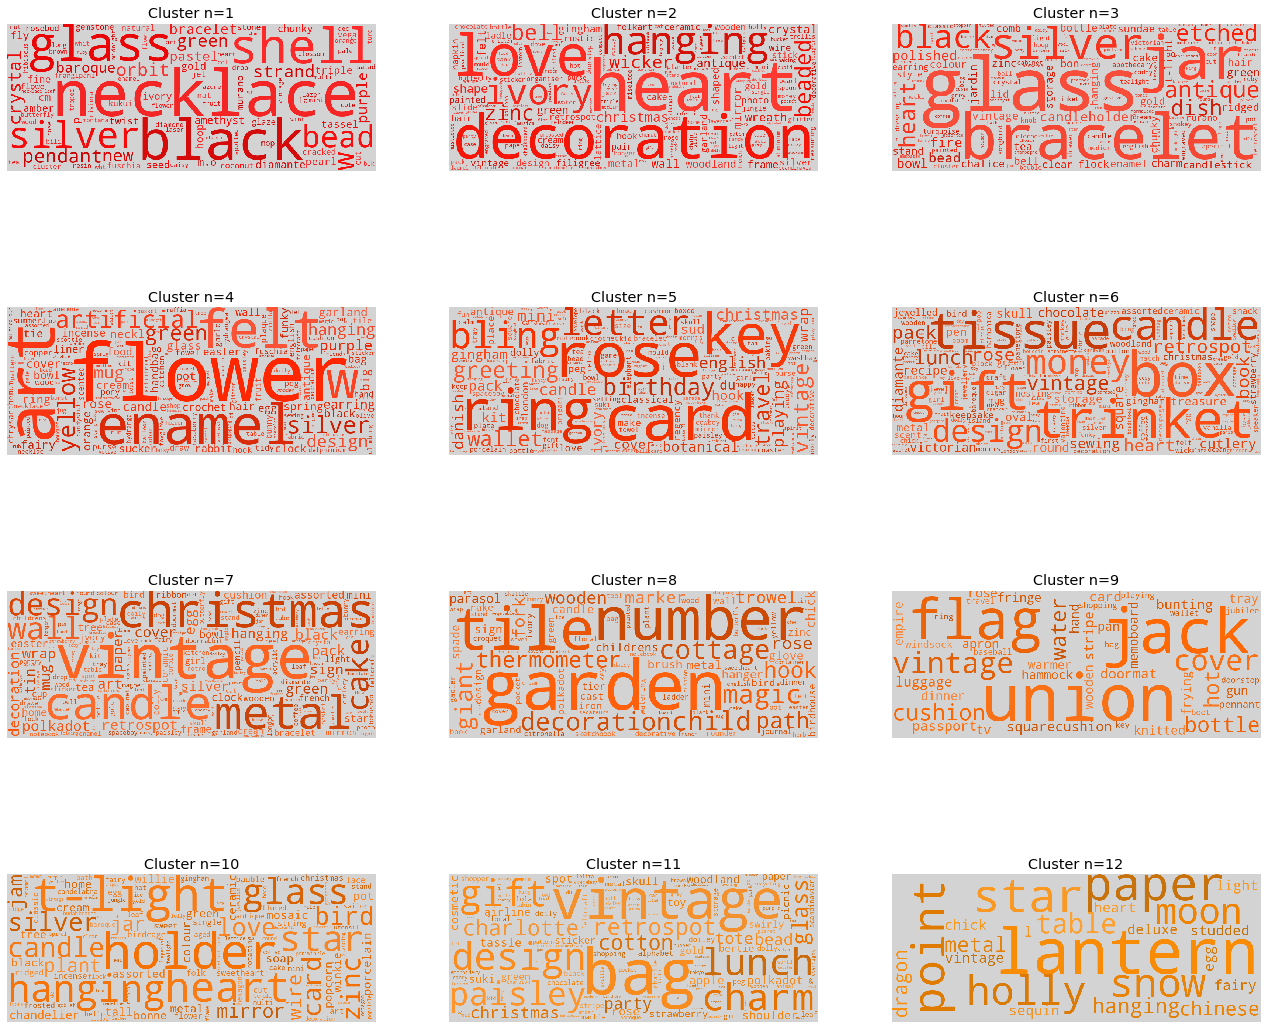

In [235]:

def desinate_color(word=None, position=None,orientation=None,font_size=None,  font_path=None, random_state=0):
    h = randint(rand_tone*3,rand_tone*3)
    s = randint(90,100)
    l = randint(40,60)
    return "hsl({}, {}%, {}%)".format(h, s, l)

fig = plt.figure(1, figsize=(20,20))
for a in range(0,best_no_of_cluster,1):    
    df_temp=df_desc[df_desc['cluster_group']==a]

    # To find the frequency
    c = Counter()
    rand_tone=a
    for i, row in df_temp.iterrows():
        c.update(row['token_list'])       
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', color_func = desinate_color, relative_scaling=0.15, random_state=0)
    wordcloud.generate_from_frequencies(c)
    axis_1 = fig.add_subplot(4,3,(a+1))
    axis_1.imshow(wordcloud)
    axis_1.axis('off')
    plt.title('Cluster n={}'.format(a+1))
    

#### Managerial Insight: 3.1

The above mentioned Clusters are a good hint on what kind of products customers are fond of. It might be used to recommend other product of the same genre to people of the same cluster.

For Example: Cluster number 5 denotes that the customer is buying for an occupation like birthday/ marriage. So, suggesting roses or cards with ring while markeing would increase the sales.


![Image of meme](https://i.chzbgr.com/full/2758957312/h8252BAEF/ahhhhh-nosorrynot-buying-it)

This could further be used to see how association of products as a offer would boost sale of the product.

### Apriori Algorithm  

Association rules analysis is a technique to uncover how items are associated to each other. There are three common ways to measure association.

*  Measure 1: Support. This says how popular an itemset is, it is number of times appear in total number of transaction. in other word we say frequency of item.

*  Measure 2: Confidence. This says how likely item Y is purchased when item X is purchased, expressed as {X -> Y}. This is measured by the proportion of transactions with item X, in which item Y also appears.

*  Measure 3: Lift. it is ratio of expected confidance to observed confidance. it is described as confidance of Y when item X was already known(x/y) to the confidance of Y when X item is unknown. in other words confidance of Y w.r.t. x and confiadnce of Y without X (means both are independent to each other).

**Support = Occurance of item / Total no of transaction**

**Confidance =  ( X Union Y) / (X)**

**Lift =  (X Union Y)/ (X) * (Y)**

More Details : https://medium.com/@fabio.italiano/the-apriori-algorithm-in-python-expanding-thors-fan-base-501950d55be9

In [236]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [237]:
df_association = pd.read_csv('data.csv', encoding="ISO-8859-1")
df_association.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [238]:
df_association.shape

(541909, 8)

In [239]:
#using only UK country data for now can check for other as well..
df_association = df_association[df_association.Country == 'United Kingdom']


In [240]:
# some spaces are there in description need to remove else later operation it will create problem..
df_association['Description'] = df_association['Description'].str.strip()

In [241]:
#some of transaction quantity is negative which can not be possible remove that.
df_association = df_association[df_association.Quantity >0]

In [242]:
#convert data in format which it require converting using pivot table and Quantity sum as values. Fill 0 if any nan values
basket = pd.pivot_table(data=df_association,index='InvoiceNo',columns='Description',values='Quantity', \
                        aggfunc='sum',fill_value=0)

In [243]:
basket

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A563185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
# Presence of the product is required
def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0

basket_sets = basket.applymap(convert_into_binary)

In [245]:
len(basket_sets)

18194

In [246]:
#remove postage item as it is just a seal which almost all transaction contain. 
basket_sets.drop(columns=['POSTAGE'],inplace=True)

In [247]:
#Call apriori function and pass minimum support here we are passing 1%. That means 1 times in total number of transaction that item was present.
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

In [248]:
#it will generate frequent itemsets using two step approch
frequent_itemsets

,support,itemsets
0,0.015005,(10 COLOUR SPACEBOY PEN)
1,0.013246,(12 MESSAGE CARDS WITH ENVELOPES)
2,0.017973,(12 PENCIL SMALL TUBE WOODLAND)
3,0.018633,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.018523,(12 PENCILS SMALL TUBE SKULL)
...,...,...
2126,0.010938,"(LUNCH BAG CARS BLUE, LUNCH BAG BLACK SKULL.,..."
2127,0.010443,"(LUNCH BAG SPACEBOY DESIGN, LUNCH BAG BLACK S..."
2128,0.010938,"(LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIG..."
2129,0.010168,"(LUNCH BAG SPACEBOY DESIGN, LUNCH BAG BLACK S..."


In [249]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=.5)
rules_mlxtend.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DOTCOM POSTAGE),(6 RIBBONS RUSTIC CHARM),0.038914,0.046994,0.011103,0.285311,6.071279,0.009274,1.333456
1,(6 RIBBONS RUSTIC CHARM),(DOTCOM POSTAGE),0.046994,0.038914,0.011103,0.236257,6.071279,0.009274,1.258390
2,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET PRINTED),0.046994,0.055403,0.011872,0.252632,4.559900,0.009268,1.263898
3,(JAM MAKING SET PRINTED),(6 RIBBONS RUSTIC CHARM),0.055403,0.046994,0.011872,0.214286,4.559900,0.009268,1.212917
4,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET WITH JARS),0.046994,0.054908,0.010608,0.225731,4.111061,0.008028,1.220625


In [250]:
# as based business use case we can sort based on confidance and lift.
df_association_business = rules_mlxtend[ (rules_mlxtend['lift'] >= 4) & (rules_mlxtend['confidence'] >= 0.8) ]

In [251]:
df_association_business

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
135,(BEADED CRYSTAL HEART PINK ON STICK),(DOTCOM POSTAGE),0.011322,0.038914,0.011048,0.975728,25.074009,0.010607,39.596746
516,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038639,0.051336,0.031714,0.820768,15.988282,0.029730,5.292945
620,(HERB MARKER BASIL),(HERB MARKER MINT),0.012751,0.012806,0.011103,0.870690,67.988530,0.010939,7.634297
621,(HERB MARKER MINT),(HERB MARKER BASIL),0.012806,0.012751,0.011103,0.866953,67.988530,0.010939,7.420287
622,(HERB MARKER BASIL),(HERB MARKER PARSLEY),0.012751,0.012532,0.011158,0.875000,69.823465,0.010998,7.899747
...,...,...,...,...,...,...,...,...,...
4111,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG RED RETROSPOT),0.014895,0.106519,0.012147,0.815498,7.655920,0.010560,4.842669
4220,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...",(RED RETROSPOT CHARLOTTE BAG),0.011707,0.049742,0.010828,0.924883,18.593718,0.010245,12.650314
4222,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...",(CHARLOTTE BAG SUKI DESIGN),0.012751,0.044190,0.010828,0.849138,19.215442,0.010264,6.335652
4223,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...",(WOODLAND CHARLOTTE BAG),0.013081,0.037540,0.010828,0.827731,22.049399,0.010337,5.586964


In [252]:
df_association_business["antecedents_string"] = df_association_business["antecedents"].apply(lambda x: ','.join(list(x))).astype("unicode")
df_association_business["consequents_string"] = df_association_business["consequents"].apply(lambda x: ','.join(list(x))).astype("unicode")

In [253]:
import ipywidgets as widgets
from ipywidgets import Dropdown
import plotly.graph_objects as go
from IPython.display import display, clear_output
from ipywidgets import widgets, Layout

#### Managerial Insight: 3.2 

##### Sellers could use the below module to find the right products for grouping to boost sales

In [254]:

type_sel = Dropdown(description="Product", options=list(df_association_business.antecedents_string.unique()),layout=Layout(width='50%'))
button = widgets.Button(description="Submit")

display(type_sel,button)


output = widgets.Output()

@output.capture()
def on_button_clicked(b):
    print("Button clicked :" +  type_sel.value)
    clear_output(wait=True)
    fig = go.Figure(
        data=[go.Bar(x= df_association_business[df_association_business.antecedents_string ==  type_sel.value].consequents_string, 
                     y = df_association_business[df_association_business.antecedents_string ==  type_sel.value].lift )],
        layout_title_text="Project Sale Lift by combining with :" + type_sel.value.capitalize()
    )
    fig.show()

button.on_click(on_button_clicked)
display(output)

Dropdown(description='Product', layout=Layout(width='50%'), options=('BEADED CRYSTAL HEART PINK ON STICK', 'PI…

Button(description='Submit', style=ButtonStyle())

Output()

The above example shows the if the seller wants to uplift the sale of Chocolates, clubbing it with Marshmallows as a basket would have 34 times more change of getting picked up by the customer. This technique could be used to club items to increase the sale of underselling items or for items with nearing expiry date.

## --Thank you, End of the notebook--